# TODO: Title
DOG BREED CLASSIFICATION USING AWS SAGEMAKER

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.
This project train a model to classify between different breeds of dogs in images and it makes use of the dog breed classification dataset.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install torchvision #I add this

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils 

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker done
import sagemaker
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from sagemaker.pytorch import PyTorch
from sagemaker.session import Session
from sagemaker import get_execution_role
import boto3
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import os
import IPython
import io
from PIL import Image
import numpy as np

[2021-12-30 16:10:44.194 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.
The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

In [ ]:
#TODO: Fetch and upload the data to AWS S3
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [4]:
sess = sagemaker.Session()
bucket= sess.default_bucket()
print("Default Bucket: {}".format(bucket))
region = sess.boto_region_name
print("AWS Region: {}".format(region))
role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-482784802372
AWS Region: us-east-1
RoleArn: arn:aws:iam::482784802372:role/service-role/AmazonSageMaker-ExecutionRole-20211213T102144


With this data we can easily sync the data up into S3!

In [ ]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/myproject3/dogImages

In [7]:
import glob
print(len(glob.glob('dogImages/train/*/*')))
print(len(glob.glob('dogImages/valid/*/*')))
print(len(glob.glob('dogImages/test/*/*')))

6680
835
836


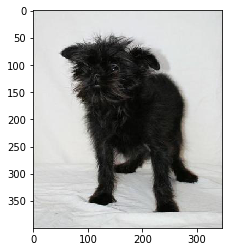

In [10]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('dogImages/train/001.Affenpinscher/Affenpinscher_00009.jpg'));

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 6)
}

In [6]:
#TODO: Create estimators for your HPs
# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]
    #hyperparameters=hyperparameters,
    #profiler_config=profiler_config,
    #debugger_hook_config=debugger_config,
    #rules=rules,

# TODO: Your HP tuner here
tuner =  HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [ ]:
# TODO: Fit your HP Tuner
# TODO: Remember to include your data channels
os.environ['SM_CHANNEL_TRAINING'] = 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/'
os.environ['SM_MODEL_DIR'] = 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/output/'

channel = {'training': 's3://sagemaker-us-east-1-482784802372/myproject3/dogImages/'}

tuner.fit(inputs=channel, wait=True) 

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [7]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_training_job() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

ValueError: No tuning job available

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [8]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [10]:
# TODO: Create and fit an estimator
# TODO: Your estimator here
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    source_dir="scripts",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    #hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [ ]:
estimator.fit(wait=True)

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


In [ ]:
# TODO: Plot a debugging output.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")


In [ ]:
# plot the loss curve: check the next three steps

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = [tensor.value(s, mode=mode) for s in steps]
    return steps, vals

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [ ]:
plot_tensor(trial, "loss")
plot_tensor(trial, "accuracy")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

In [ ]:
# TODO: Display the profiler output
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge") # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint
with open("/root/myproject3/550435539.jpg", 'rb') as f:
    image_b = f.read()
image = Image.open(io.BytesIO(image_b))  # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)
print(response)
np.argmax(response, 1)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()